In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DATASET.zip

Streaming output truncated to the last 5000 lines.
  inflating: DATASET/TRAIN/R/R_5000.jpg  
  inflating: DATASET/TRAIN/R/R_5001.jpg  
  inflating: DATASET/TRAIN/R/R_5002.jpg  
  inflating: DATASET/TRAIN/R/R_5003.jpg  
  inflating: DATASET/TRAIN/R/R_5004.jpg  
  inflating: DATASET/TRAIN/R/R_5005.jpg  
  inflating: DATASET/TRAIN/R/R_5006.jpg  
  inflating: DATASET/TRAIN/R/R_5007.jpg  
  inflating: DATASET/TRAIN/R/R_5008.jpg  
  inflating: DATASET/TRAIN/R/R_5009.jpg  
  inflating: DATASET/TRAIN/R/R_5010.jpg  
  inflating: DATASET/TRAIN/R/R_5011.jpg  
  inflating: DATASET/TRAIN/R/R_5012.jpg  
  inflating: DATASET/TRAIN/R/R_5013.jpg  
  inflating: DATASET/TRAIN/R/R_5014.jpg  
  inflating: DATASET/TRAIN/R/R_5015.jpg  
  inflating: DATASET/TRAIN/R/R_5016.jpg  
  inflating: DATASET/TRAIN/R/R_5017.jpg  
  inflating: DATASET/TRAIN/R/R_5018.jpg  
  inflating: DATASET/TRAIN/R/R_5019.jpg  
  inflating: DATASET/TRAIN/R/R_5020.jpg  
  inflating: DATASET/TRAIN/R/R_5021.jpg  
  inflating: DATASET/TRAI

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import urllib
import itertools
import random, os, glob
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [ ]:
!ls


DATASET  drive	sample_data


In [ ]:
dir_path = "./DATASET/"

In [ ]:
target_size = (224, 224)
waste_labels = {"N":0, "O":1, "R":2}

In [ ]:
def load_dataset(path):
  x = []
  labels = []
  image_paths = sorted(list(paths.list_images(path)))
  for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    x.append(img)
    label = image_path.split(os.path.sep)[-2]
    labels.append(waste_labels[label])
  x, labels = shuffle(x, labels, random_state=42)
  input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
  print("X shape: ", np.array(x).shape)
  print(f"Number of Labels: {len(np.unique(labels))} , Number of Observation: {len(labels)}")
  print("Input Shape: ", input_shape)
  return x, labels, input_shape

In [ ]:
x, labels, input_shape = load_dataset(dir_path)

X shape:  (25471, 224, 224, 3)
Number of Labels: 3 , Number of Observation: 25471
Input Shape:  (224, 224, 3)


In [ ]:
def visualizeation_img(image_batch, labels, num_of_img):
  plt.figure(figsize=(10,10))
  for n in range(num_of_img):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=len(np.unique(labels)))[n] == 1][0].title())
    plt.axis("off")

In [ ]:
train_path = "./DATASET/TRAIN/"
test_path = "./DATASET/TEST/"
def CNN_data_preparation():
  train = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1,
                             rescale=1./255,
                             shear_range=0.1,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
  test = ImageDataGenerator(rescale=1/255, validation_split=0.1)
  train_generator = train.flow_from_directory(directory=train_path,
                                              target_size=(target_size),
                                              class_mode="categorical",
                                              subset="training")
  test_generator = test.flow_from_directory(directory=test_path,
                                            target_size=(target_size),
                                            batch_size=251,
                                            class_mode="categorical",
                                            subset="validation")
  return train_generator, test_generator

In [ ]:
train_generator, test_generator = CNN_data_preparation()

Found 20309 images belonging to 3 classes.
Found 290 images belonging to 3 classes.


In [ ]:
def CNN_create_and_fit_model(train_generator, test_generator, summary=True, fit=True, epochs=100):
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Flatten())

  model.add(Dense(units=64, activation="relu"))
  model.add(Dropout(rate=0.2))

  model.add(Dense(units=32, activation="relu"))
  model.add(Dropout(rate=0.2))

  model.add(Dense(units=3, activation="softmax"))

  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

  callbacks = [EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"), 
              ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]
  
  if summary:
    model.summary()
  
  if fit:
    history = model.fit_generator(generator=train_generator, epochs=epochs, validation_data=test_generator, 
                                callbacks=callbacks, workers=4, steps_per_epoch=10, validation_steps=251//32)

  return model, history

In [ ]:
model, history = CNN_create_and_fit_model(train_generator, test_generator)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 32)      

In [ ]:
def CNN_model_evaluate(model):
  loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)
  print("Test Accuracy: %.2f" % (100 * acc))
  print("Test Loss: %.2f" % (100 * loss))
  print("Test Precision: %.2f" % (100 * precision))
  print("Test Recall: %.2f" % (100 * recall))

  X_test, y_test = test_generator.next()
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(y_test, axis=1)
  target_names = list(waste_labels.keys())
  print(classification_report(y_test, y_pred, target_names=target_names))

  plt.figure(figsize=(20,5))
  plt.subplot(1,2,1)
  plt.plot(history.history["acc"], color="r", label="Training Accuracy")
  plt.plot(history.history["val_acc"], color="b", label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Accuracy", fontsize=16)
  plt.ylim([min(plt.ylim()),1])
  plt.title("Training and Validation Accuracy", fontsize=16)

  plt.subplot(1,2,2)
  plt.plot(history.history["loss"], color="r", label="Training Loss")
  plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
  plt.legend(loc="upper right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Loss", fontsize=16)
  plt.ylim([0, max(plt.ylim())])
  plt.title("Training and Validation Loss", fontsize=16)

  return y_test, y_pred

In [ ]:
model.save('model.h5')

2/2 [==============================] - 1s 29ms/step - loss: 0.5641 - precision_2: 0.8144 - recall_2: 0.7414 - acc: 0.7724
Test Accuracy: 77.24
Test Loss: 56.41
Test Precision: 81.44
Test Recall: 74.14
8/8 [==============================] - 0s 17ms/step
              precision    recall  f1-score   support

           N       0.14      0.03      0.05        32
           O       0.86      0.97      0.91       123
           R       0.73      0.80      0.77        96

    accuracy                           0.78       251
   macro avg       0.58      0.60      0.58       251
weighted avg       0.72      0.78      0.74       251



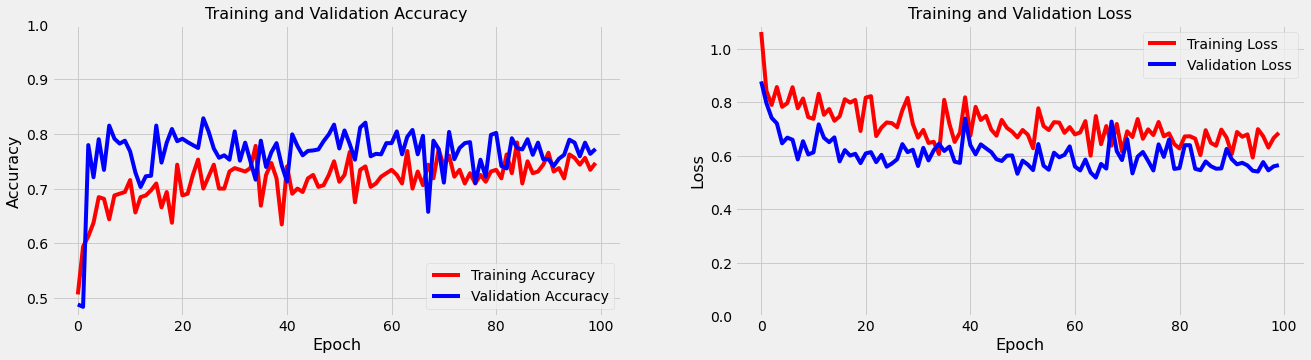

In [ ]:
y_test, y_pred = CNN_model_evaluate(model)

In [ ]:
def CNN_model_testing(path):
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0
  p = model.predict(img.reshape(1,224,224,3))
  predicted_class = np.argmax(p[0])
  return img, p, predicted_class

In [ ]:
img, p, predicted_class = CNN_model_testing("/content/DATASET/TEST/R/R_10024.jpg")
waste_labels = {0:"N", 1:"O", 2:"R"}
def plot_model_testing(img, p, predicted_class):
  plt.axis("off")
  plt.imshow(img.squeeze())
  plt.title("Maximum Probabilty: " + str(np.max(p[0], axis=-1)) + "\n" + "Predicted Class: " + str(waste_labels[predicted_class]))
  plt.imshow(img);

1/1 [==============================] - 0s 84ms/step


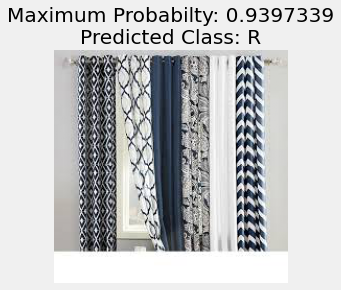

In [ ]:
plot_model_testing(img, p, predicted_class)